# Traveling Salesperson Problem

In [2]:
from utils import make_tsp_qp, randomize_cities, brute_force_tsp, draw_tour, reorder

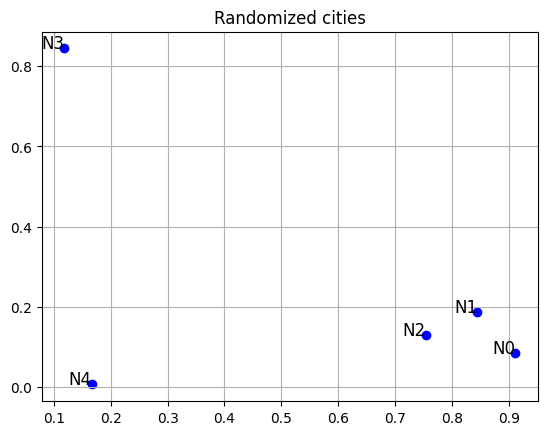

array([[ 0,  1,  1, 10,  7],
       [ 1,  0,  1,  9,  7],
       [ 1,  1,  0,  9,  6],
       [10,  9,  9,  0,  8],
       [ 7,  7,  6,  8,  0]])

In [3]:
# Create a random TSP problem
weights = randomize_cities(5)
weights

## Brute force solve

Best order from brute force = (0, 1, 3, 4, 2) with total distance = 25


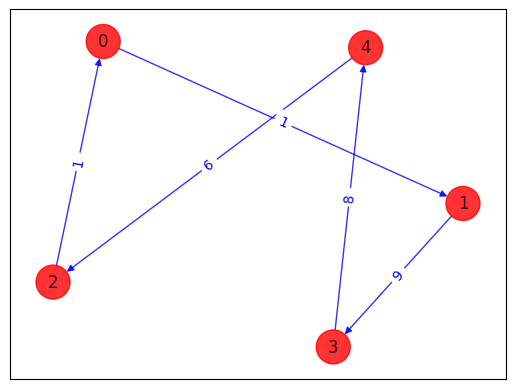

In [4]:
best_order, best_distance = brute_force_tsp(weights)
draw_tour(weights, best_order)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

## Formulating QUBO

For $N$ cities, use $N^2$ binary variables x(i,p), where i represents the index of a city and p represents the order of the city in the route. In other words, if city i is visited at step p of the route, then x(i,p) = 1.

Constraints\
This euations ensure that each city is visited only once, and each step of the route is in one city.
$
\begin{gather}
\sum_{p=0}^{N-1} ( 1 - \sum_{i=0}^{N-1} x(i, p) )^2 = 0 \\
\sum_{i=0}^{N-1} ( 1 - \sum_{p=0}^{N-1} x(i, p) )^2 = 0 \\ 
\sum_{i=0}^{N-1} x_{i, p} = 1,\ for\ all\ p \\
\sum_{p=0}^{N-1} x_{i, p} = 1,\ for\ all\ i \\
\end{gather}
$

Objective\
Find the shortest Hamiltonian cycle in a graph
$
\begin{gather}
C(x) = \sum_{i, j} w_{i, j} \sum_{p=0}^{N-1} x_{i, p}x_{j, p + 1}  \\
\end{gather}
$

In [5]:
from qiskit_optimization.converters import QuadraticProgramToQubo

# making quadratic program from TSP weights
quadratic_program = make_tsp_qp(weights)
# conveerts the quadratic program to QUBO, with a penalty of 10 (constant to scale the constraints)
qp2qubo = QuadraticProgramToQubo(penalty=10)
qubo = qp2qubo.convert(quadratic_program)
# converts the QUBO to an Ising Hamiltonian
qubitOp, offset = qubo.to_ising()

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 497.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIIIIII

## Classical Solver

In [6]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver


# 4 cities and above crashes the kernel
# exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
# result = exact.solve(qubo)
# print(result.prettyprint())


## Running on quantum computer

In [10]:
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_algorithms import QAOA

from qiskit_aer.primitives import Sampler

optimizer = L_BFGS_B(maxiter=100) # L_BFGS_B optimizer is used for its efficiency in terms of required evaluations of the objective functions, noiselless case

# QAOA measurement object
qaoa_mes = QAOA(sampler=Sampler(), optimizer=optimizer, reps=1, callback=print)
result = qaoa_mes.compute_minimum_eigenvalue(qubitOp)

print(result)



1 [5.073511876207112, 2.180571322879022] (2.2626953125+0j) {'shots': 1024, 'simulator_metadata': {'batched_shots_optimization': False, 'required_memory_mb': 512, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 25, 'num_clbits': 25, 'time_taken': 5.5594308, 'sample_measure_time': 0.0363892, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24]], 'max_memory_mb': 16236, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'cost_factor': 1.8, 'threshold': 14, 'method': 'unitary', 'max_fused_qubits': 5, 'time_taken': 0.0030156, 'p

In [28]:
# reorder(result.x, len(weights))
import numpy as np
values = list(result.eigenstate.values())
n = int(np.log2(len(values)))
k = np.argmax(np.abs(values))
print(k)

0
